# NLME inference versus filter inference: Cancer growth

In [1]:
import os
import string

import chi
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pints
from scipy.stats import gaussian_kde
import seaborn as sns
import xarray as xr
sns.set_theme()

from exponential_growth_model import ExponentialGrowthModel

The data-generating model is a hierarchical exponential growth model governed
by

$$
    p(y, \psi | \theta , t) = p(y | \psi , t)\, p(\psi | \theta),
$$

where $\psi = (y_0, \lambda, \sigma)$ and
$\theta = (\mu_{y_0}, \mu_{\lambda}, \sigma_{y_0}, \sigma_{\lambda}, \theta_{\sigma})$.
The measurements of individuals are governed by a distribution defined by the
mechanistic model-error model pair

$$
    p(y | \psi , t) = \mathcal{N}(y | y_0\mathrm{e}^{\lambda t}, \sigma ^2),
$$

and the inter-individual variability is governed by the population model

$$
    p(\psi | \theta) =
        \mathcal{N}(y_0 | \mu_{y_0}, \sigma ^2_{y_0})\,
        \mathcal{N}(\lambda | \mu_{\lambda}, \sigma ^2_{\lambda})\,
        \delta (\sigma - \theta_{\sigma}).
$$

### Results

### 1. Filter inference vs. NLME inference

Import results

In [2]:
# Import data
directory = os.getcwd()
measurements_df = pd.read_csv(directory + '/data/1_cancer_growth_data_15.csv')

# Reshape data to numpy array of shape (n_ids_per_t, n_output, n_times)
n_ids = len(measurements_df.ID.unique())
output = measurements_df.Observable.unique()[0]
n_outputs = 1
times = np.sort(measurements_df.Time.unique())
n_ids_per_t = n_ids // len(times)
measurements = np.empty(shape=(n_ids_per_t, n_outputs, len(times)))
measurements_df = measurements_df[measurements_df.Observable == output]
for idt, time in enumerate(times):
    mask = measurements_df.Time == time
    measurements[:, 0, idt] = measurements_df[mask].Value.values

# Define true parameters
true_parameters = [
    10,    # Mean initial condition
    1,     # Std. initial condition
    2,     # Mean exponential growth
    0.5,   # Std. exponential growth
    0.8]   # Sigma

# Define predictive model
mechanistic_model = ExponentialGrowthModel()
error_model = chi.GaussianErrorModel()
predictive_model = chi.PredictiveModel(mechanistic_model, error_model)

# Define population model
population_model = chi.ComposedPopulationModel([
    chi.GaussianModel(
        n_dim=2, dim_names=['Initial count', 'Growth rate'],
        centered=True),
    chi.PooledModel(dim_names=['Sigma'])])

# Define prior distribution
log_prior = [
    pints.GaussianLogPrior(9, 3),        # Mean initial condition
    pints.LogNormalLogPrior(2, 1),       # Std. initial condition
    pints.GaussianLogPrior(5, 3),        # Mean exponential growth
    pints.LogNormalLogPrior(0.5, 1),     # Std. exponential growth
    pints.GaussianLogPrior(0.8, 0.1)]    # Sigma

# Import NLME inference results
nlme_results = xr.load_dataset(
    directory + '/posteriors/1_nlme_inference_cancer_growth_15.nc')

# Import filter inference results
filter_results = xr.load_dataset(
    directory + '/posteriors/2_filter_inference_cancer_growth_15.nc')

Visualise results

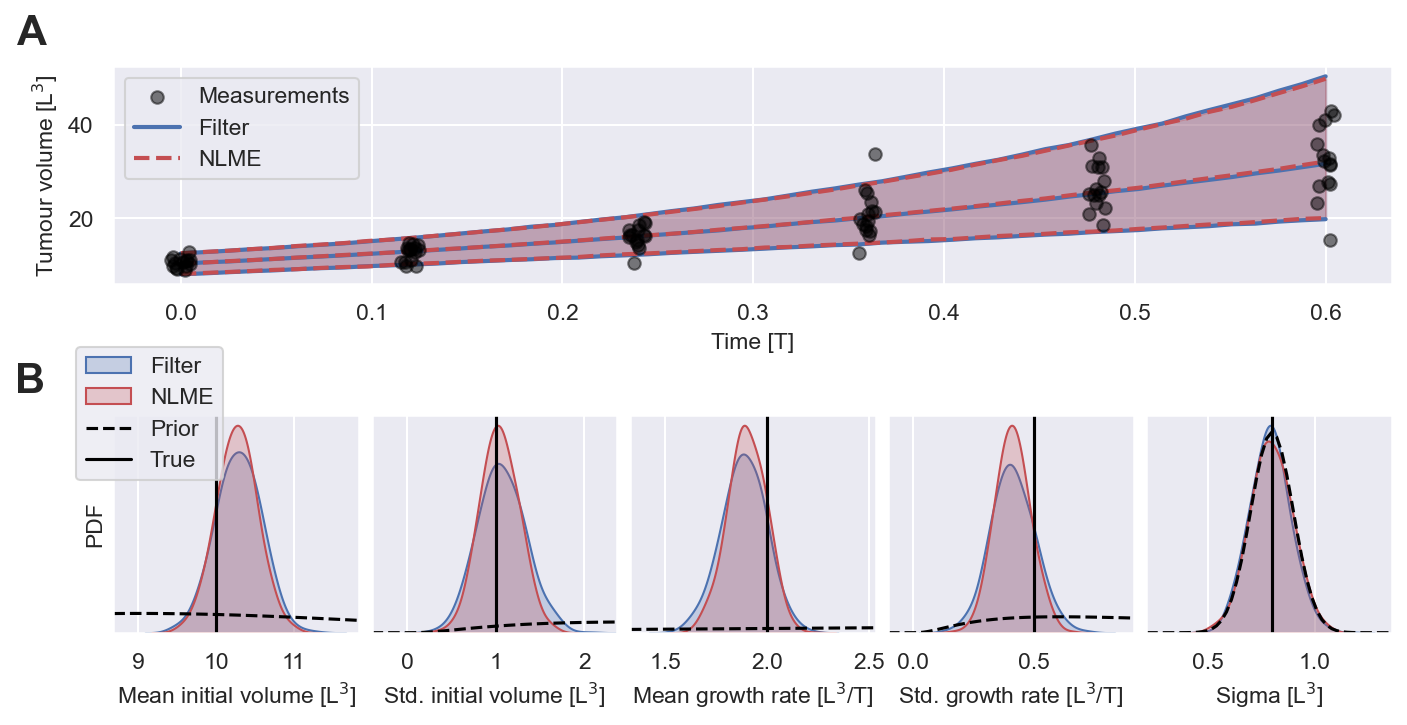

In [9]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1000 // my_dpi), dpi=150)
outer = gridspec.GridSpec(2, 1, hspace=0.6)

# Create time series axes
inner1 = gridspec.GridSpecFromSubplotSpec(
    1, 5, subplot_spec=outer[1], wspace=0.05)

# Create axis for data
axes = []
axes.append(plt.Subplot(fig, outer[0]))

# Create axes for NLME inference results
axes.append(plt.Subplot(fig, inner1[0]))
axes.append(plt.Subplot(fig, inner1[1]))
axes.append(plt.Subplot(fig, inner1[2]))
axes.append(plt.Subplot(fig, inner1[3]))
axes.append(plt.Subplot(fig, inner1[4]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Add subplot labels
# Label subplot groups
axes[0].text(
    -0.075, 1.1, string.ascii_uppercase[0], transform=axes[0].transAxes,
    size=20, weight='bold')
axes[1].text(
    -0.4, 1.1, string.ascii_uppercase[1], transform=axes[1].transAxes,
    size=20, weight='bold')

# Plot measurements
for idm, meas in enumerate(measurements):
    label = None
    if idm == 0:
        label = 'Measurements'
    jitter = np.random.uniform(-0.005, 0.005, size=len(times))
    axes[0].scatter(
        times + jitter, meas[0], color='black', marker='o', alpha=0.5,
        label=label, zorder=10)

# Plot population filter inference results (measurement space)
n_samples = 5000
parameters = [
    'Mean Initial count', 'Mean Growth rate', 'Std. Initial count',
    'Std. Growth rate', 'Sigma Count']
parameters = np.vstack([
    filter_results[p].values.flatten() for p in parameters]).T
parameters = parameters[
    np.random.choice(np.arange(len(parameters)), size=n_samples, replace=True)]
samples = np.empty(shape=(n_samples, 3))
for ids, params in enumerate(parameters):
    samples[ids, :] = population_model.sample(params)[0]

t = np.linspace(np.min(times), np.max(times))
n_t = len(t)
predictive_model = chi.PredictiveModel(mechanistic_model, error_model)
simulated_measurements = np.empty(shape=(n_samples, n_t))
for ids, sample in enumerate(samples):
    simulated_measurements[ids, :] = predictive_model.sample(
        parameters=sample, times=t, return_df=False)[0, :, 0]
fifth_percentile = np.percentile(simulated_measurements, q=5, axis=0)
median = np.percentile(simulated_measurements, q=50, axis=0)
ninetyfifth_percentile = np.percentile(simulated_measurements, q=95, axis=0)
axes[0].plot(
    t, fifth_percentile, color=sns.color_palette()[0], linewidth=2)
axes[0].plot(
    t, ninetyfifth_percentile, color=sns.color_palette()[0], linewidth=2)
axes[0].fill_between(
    t, fifth_percentile, ninetyfifth_percentile,
    color=sns.color_palette()[0], alpha=0.3)
axes[0].plot(
    t, median, color=sns.color_palette()[0], label='Filter', linewidth=2)

# Plot population NLME inference results (measurement space)
n_samples = 5000
parameters = [
    'Mean Initial count', 'Mean Growth rate', 'Std. Initial count',
    'Std. Growth rate', 'Pooled Sigma']
parameters = np.vstack([
    nlme_results[p].values.flatten() for p in parameters]).T
parameters = parameters[
    np.random.choice(np.arange(len(parameters)), size=n_samples, replace=True)]
samples = np.empty(shape=(n_samples, 3))
for ids, params in enumerate(parameters):
    samples[ids, :] = population_model.sample(params)[0]

t = np.linspace(np.min(times), np.max(times))
n_t = len(t)
predictive_model = chi.PredictiveModel(mechanistic_model, error_model)
simulated_measurements = np.empty(shape=(n_samples, n_t))
for ids, sample in enumerate(samples):
    simulated_measurements[ids, :] = predictive_model.sample(
        parameters=sample, times=t, return_df=False)[0, :, 0]
fifth_percentile = np.percentile(simulated_measurements, q=5, axis=0)
median = np.percentile(simulated_measurements, q=50, axis=0)
ninetyfifth_percentile = np.percentile(simulated_measurements, q=95, axis=0)
axes[0].plot(
    t, fifth_percentile, color=sns.color_palette()[3], linestyle='dashed',
    linewidth=2)
axes[0].plot(
    t, ninetyfifth_percentile, color=sns.color_palette()[3],
    linestyle='dashed', linewidth=2)
axes[0].fill_between(
    t, fifth_percentile, ninetyfifth_percentile,
    color=sns.color_palette()[3], alpha=0.3)
axes[0].plot(
    t, median, color=sns.color_palette()[3], label='NLME', linestyle='dashed',
    linewidth=2)
axes[0].set_xlabel('Time [T]', fontsize=fontsize)
axes[0].set_ylabel(r'Tumour volume [L$^3$]', fontsize=fontsize)
axes[0].tick_params(labelsize=fontsize)
axes[0].legend(fontsize=fontsize)

# Plot filter inference results
parameters = [
    'Mean Initial count', 'Std. Initial count', 'Mean Growth rate',
    'Std. Growth rate', 'Sigma Count']
for idp, param in enumerate(parameters):
    sns.kdeplot(
        filter_results[param].values.flatten(), fill=True, ax=axes[idp+1],
        label='Filter', bw_adjust=1.5, color=sns.color_palette()[0])
    min_value = np.min(filter_results[param].values.flatten())
    max_value = np.max(filter_results[param].values.flatten())
    span = max_value - min_value
    min_value -= 0.5 * span
    max_value += 0.5 * span

# Plot NLME inference results
parameters = [
    'Mean Initial count', 'Std. Initial count', 'Mean Growth rate',
    'Std. Growth rate', 'Pooled Sigma']
for idp, param in enumerate(parameters):
    sns.kdeplot(
        nlme_results[param].values.flatten(), fill=True, ax=axes[idp+1],
        label='NLME', bw_adjust=1.5, color=sns.color_palette()[3])
    min_value = np.min(nlme_results[param].values.flatten())
    max_value = np.max(nlme_results[param].values.flatten())
    span = max_value - min_value
    min_value -= 0.5 * span
    max_value += 0.5 * span

    # Plot prior
    xs = np.linspace(min_value, max_value)
    evals = []
    for x in xs:
        evals.append(np.exp(log_prior[idp]([x])))
    axes[idp+1].plot(xs, evals, color='black', linestyle='--', label='Prior')
    axes[idp+1].set_xlim([min_value, max_value])

for idp, param in enumerate(true_parameters):
    axes[idp+1].axvline(x=param, color='black', label='True')
names = [
    r'Mean initial volume [L$^3$]', r'Std. initial volume [L$^3$]',
    r'Mean growth rate [L$^3$/T]', r'Std. growth rate [L$^3$/T]',
    r'Sigma [L$^3$]']
for idn, n in enumerate(names):
    axes[idn+1].set_xlabel(n, fontsize=fontsize)
    if idn == 0:
        axes[idn+1].set_ylabel('PDF', fontsize=fontsize)
        axes[idn+1].set_yticks([])
    else:
        axes[idn+1].get_yaxis().set_visible(False)
    axes[idn+1].tick_params(labelsize=fontsize)

axes[1].legend(loc=[-0.15, 0.7], fontsize=int(fontsize))

# Export figure
plt.savefig(
    directory + '/4_nlme_inference_versus_filter_inference.tif',
    bbox_inches='tight')
plt.savefig(
    directory + '/4_nlme_inference_versus_filter_inference.pdf',
    bbox_inches='tight')

plt.show()

### 2. Inference from increasing numbers of measured individuals

Import results

In [119]:
# Import filter inference results
n_ids_per_t = [15, 45, 135, 405]
filter_results = []
for idn, n in enumerate(n_ids_per_t):
    filter_results.append(xr.load_dataset(
        directory + '/posteriors/%d_filter_inference_cancer_growth_%d.nc'
        % (idn+2, n)))
suppl = []
for idn, n in enumerate(n_ids_per_t):
    suppl.append(xr.load_dataset(
        directory + '/posteriors'
        + '/%d_filter_inference_cancer_growth_N_equal_S_%d.nc'
        % (idn+2, n)))
nlme_results = []
for n in n_ids_per_t:
    nlme_results.append(xr.load_dataset(
        directory + '/posteriors/1_nlme_inference_cancer_growth_%d.nc' % n))
nlme_results[0] = nlme_results[0].rename_vars({
    'Mean Initial count': 'Mean Initial volume'})
nlme_results[0] = nlme_results[0].rename_vars({
    'Std. Initial count': 'Std. Initial volume'})

# Define true parameters
true_parameters = [
    10,    # Mean initial condition
    2,     # Mean exponential growth
    1,     # Std. initial condition
    0.5,   # Std. exponential growth
    0.8]   # Sigma


Visualise inferred posteriors

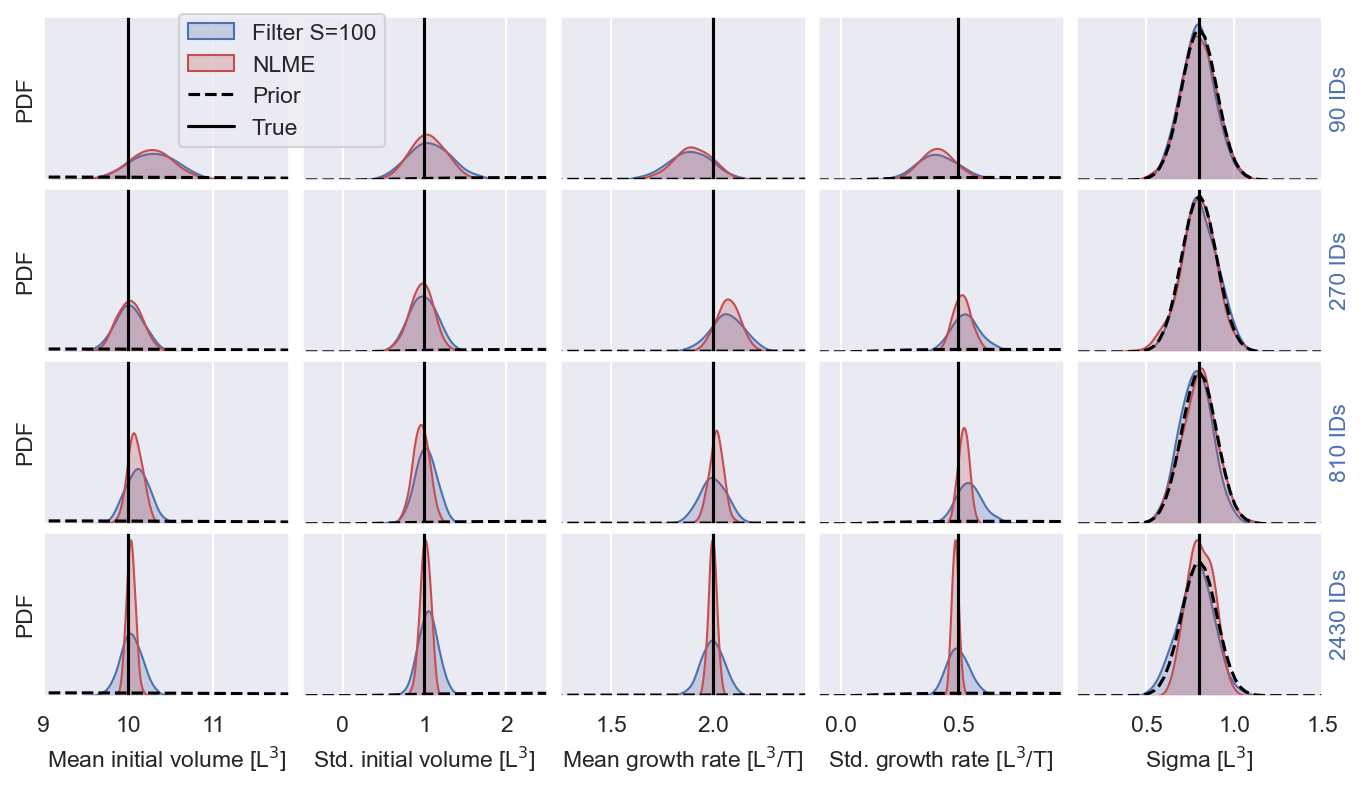

In [122]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1200 // my_dpi), dpi=150)
outer = gridspec.GridSpec(4, 1, hspace=0.05)

# Create time series axes
inner1 = gridspec.GridSpecFromSubplotSpec(
    1, 5, subplot_spec=outer[0], wspace=0.05)
inner2 = gridspec.GridSpecFromSubplotSpec(
    1, 5, subplot_spec=outer[1], wspace=0.05)
inner3 = gridspec.GridSpecFromSubplotSpec(
    1, 5, subplot_spec=outer[2], wspace=0.05)
inner4 = gridspec.GridSpecFromSubplotSpec(
    1, 5, subplot_spec=outer[3], wspace=0.05)


# Create axis for data
axes = []
axes.append(plt.Subplot(fig, inner1[0]))
axes.append(plt.Subplot(fig, inner1[1]))
axes.append(plt.Subplot(fig, inner1[2]))
axes.append(plt.Subplot(fig, inner1[3]))
axes.append(plt.Subplot(fig, inner1[4]))
axes.append(plt.Subplot(fig, inner2[0]))
axes.append(plt.Subplot(fig, inner2[1]))
axes.append(plt.Subplot(fig, inner2[2]))
axes.append(plt.Subplot(fig, inner2[3]))
axes.append(plt.Subplot(fig, inner2[4]))
axes.append(plt.Subplot(fig, inner3[0]))
axes.append(plt.Subplot(fig, inner3[1]))
axes.append(plt.Subplot(fig, inner3[2]))
axes.append(plt.Subplot(fig, inner3[3]))
axes.append(plt.Subplot(fig, inner3[4]))
axes.append(plt.Subplot(fig, inner4[0]))
axes.append(plt.Subplot(fig, inner4[1]))
axes.append(plt.Subplot(fig, inner4[2]))
axes.append(plt.Subplot(fig, inner4[3]))
axes.append(plt.Subplot(fig, inner4[4]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

axes[0].sharey(axes[5])
axes[5].sharey(axes[10])
axes[10].sharey(axes[15])
axes[1].sharey(axes[6])
axes[6].sharey(axes[11])
axes[11].sharey(axes[16])
axes[2].sharey(axes[7])
axes[7].sharey(axes[12])
axes[12].sharey(axes[17])
axes[3].sharey(axes[8])
axes[8].sharey(axes[13])
axes[13].sharey(axes[18])

# Plot filter inference results
parameters = [
    'Mean Initial count', 'Std. Initial count', 'Mean Growth rate',
    'Std. Growth rate', 'Sigma Count']
parameters2 = [
    'Mean Initial volume', 'Std. Initial volume', 'Mean Growth rate',
    'Std. Growth rate', 'Pooled Sigma']
parameters3 = [
    'Mean Initial volume', 'Std. Initial volume', 'Mean Growth rate',
    'Std. Growth rate', 'Sigma Tumour volume']
for idr, r in enumerate(filter_results):
    for idp, param in enumerate(parameters):
        sns.kdeplot(
            r[param].values.flatten(), fill=True, ax=axes[idr*5+idp],
            label='Filter S=100', bw_adjust=1.5, color=sns.color_palette()[0])
        sns.kdeplot(
            nlme_results[idr][parameters2[idp]].values.flatten(),
            fill=True, ax=axes[idr*5+idp],
            label='NLME', bw_adjust=1.5, color=sns.color_palette()[3])
        # sns.kdeplot(
        #     suppl[idr][parameters3[idp]].values.flatten(), fill=False,
        #     ax=axes[idr*5+idp], label='Filter S=N', bw_adjust=1.5,
        #     color=sns.color_palette()[2])
        min_value = np.min(filter_results[0][param].values.flatten())
        max_value = np.max(filter_results[0][param].values.flatten())
        span = max_value - min_value
        min_value -= 0.5 * span
        max_value += 0.5 * span

        # Plot prior
        xs = np.linspace(min_value, max_value)
        evals = []
        for x in xs:
            evals.append(np.exp(log_prior[idp]([x])))
        axes[idr*5+idp].plot(
            xs, evals, color='black', linestyle='--', label='Prior')
        if idr == 0:
            axes[idr*5+idp].set_xlim([min_value, max_value])

true_parameters = [
    10,    # Mean initial condition
    1,     # Std. initial condition
    2,     # Mean exponential growth
    0.5,   # Std. exponential growth
    0.8]   # Sigma
for idp, param in enumerate(true_parameters * 4):
    axes[idp].axvline(x=param, color='black', label='True')
names = [
    r'Mean initial volume [L$^3$]', r'Std. initial volume [L$^3$]',
    r'Mean growth rate [L$^3$/T]', r'Std. growth rate [L$^3$/T]',
    r'Sigma [L$^3$]'] * 4
for idn, n in enumerate(names):
    if idn in [0, 5, 10, 15]:
        axes[idn].set_ylabel('PDF', fontsize=fontsize)
        axes[idn].set_yticks([])
    else:
        axes[idn].set_yticks([])
        axes[idn].set_yticklabels(labels=[], visible=False)
        axes[idn].set_ylabel('')

    if idn >= 15:
        axes[idn].set_xlabel(n, fontsize=fontsize)
        axes[idn].tick_params(labelsize=fontsize)
    else:
        # axes[idn].set_xticks([])
        axes[idn].set_xticklabels(labels=[], visible=False)

# Labelling
labels = ['90 IDs', '270 IDs', '810 IDs', '2430 IDs']
for idx, ax in enumerate([axes[4], axes[9], axes[14], axes[19]]):
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(labels[idx], fontsize=fontsize, color=sns.color_palette()[0])
for ida, ax in enumerate(axes):
    if ida % 5 == 0:
        ax.set_xlim([9, 11.9])
    elif ida % 5 == 1:
        ax.set_xlim([-0.5, 2.5])
    elif ida % 5 == 2:
        ax.set_xlim([1.25, 2.45])
    elif ida % 5 == 3:
        ax.set_xlim([-0.1, 0.95])
    else:
        ax.set_xlim([0.1, 1.5])
axes[1].legend(loc=[-0.5, 0.2], fontsize=int(fontsize))

# Export figure
plt.savefig(
    directory + '/S1_nlme_inference_versus_filter_inference.tif',
    bbox_inches='tight')
plt.savefig(
    directory + '/S1_nlme_inference_versus_filter_inference.pdf',
    bbox_inches='tight')

plt.show()

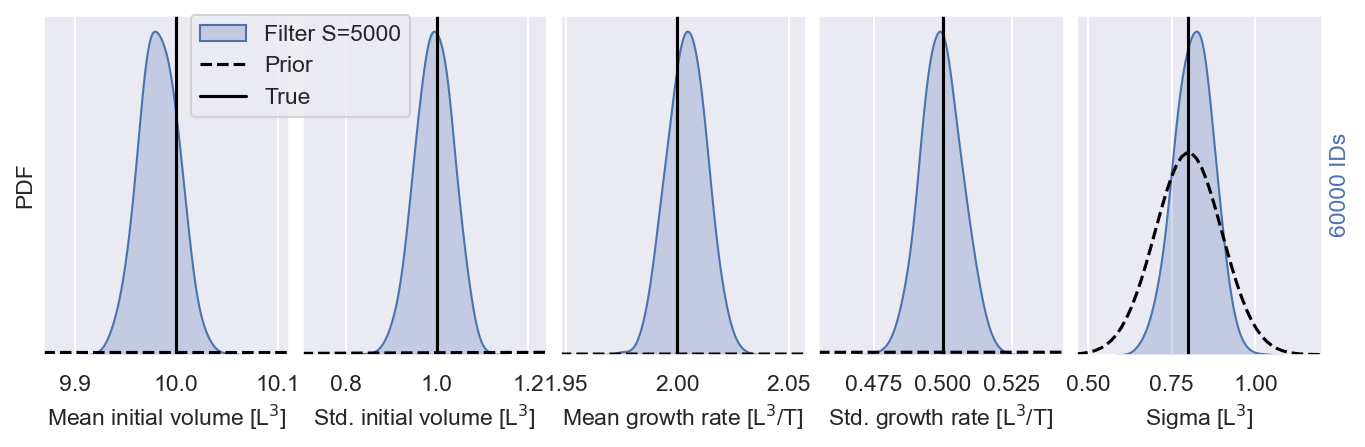

In [116]:
# Import supplementary data
suppl = xr.load_dataset(
    directory + '/posteriors'
    + '/S2_filter_inference_cancer_growth_N_equal_S_10000.nc')

# Define true parameters
true_parameters = [
    10,    # Mean initial condition
    1,     # Std. initial condition
    2,     # Mean exponential growth
    0.5,   # Std. exponential growth
    0.8]   # Sigma

# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 1, hspace=0.05)

# Create time series axes
inner1 = gridspec.GridSpecFromSubplotSpec(
    1, 5, subplot_spec=outer[0], wspace=0.05)


# Create axis for data
axes = []
axes.append(plt.Subplot(fig, inner1[0]))
axes.append(plt.Subplot(fig, inner1[1]))
axes.append(plt.Subplot(fig, inner1[2]))
axes.append(plt.Subplot(fig, inner1[3]))
axes.append(plt.Subplot(fig, inner1[4]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot filter inference results
parameters = [
    'Mean Initial volume', 'Std. Initial volume', 'Mean Growth rate',
    'Std. Growth rate', 'Sigma Tumour volume']
for idp, param in enumerate(parameters):
    sns.kdeplot(
        suppl[param].values.flatten(), fill=True,
        ax=axes[idp], label='Filter S=5000', bw_adjust=1.5,
        color=sns.color_palette()[0])
    min_value = np.min(suppl[param].values.flatten())
    max_value = np.max(suppl[param].values.flatten())
    span = max_value - min_value
    min_value -= 0.5 * span
    max_value += 0.5 * span

    # Plot prior
    xs = np.linspace(min_value, max_value)
    evals = []
    for x in xs:
        evals.append(np.exp(log_prior[idp]([x])))
    axes[idp].plot(
        xs, evals, color='black', linestyle='--', label='Prior')
    axes[idp].set_xlim([min_value, max_value])

for idp, param in enumerate(true_parameters):
    axes[idp].axvline(x=param, color='black', label='True')
names = [
    r'Mean initial volume [L$^3$]', r'Std. initial volume [L$^3$]',
    r'Mean growth rate [L$^3$/T]', r'Std. growth rate [L$^3$/T]',
    r'Sigma [L$^3$]']
for idn, n in enumerate(names):
    if idn == 0:
        axes[idn].set_ylabel('PDF', fontsize=fontsize)
        axes[idn].set_yticks([])
    else:
        axes[idn].set_yticks([])
        axes[idn].set_yticklabels(labels=[], visible=False)
        axes[idn].set_ylabel('')

    axes[idn].set_xlabel(n, fontsize=fontsize)
    axes[idn].tick_params(labelsize=fontsize)

# Labelling
labels = ['60000 IDs']
for idx, ax in enumerate([axes[-1]]):
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(labels[idx], fontsize=fontsize, color=sns.color_palette()[0])
axes[1].legend(loc=[-0.45, 0.7], fontsize=int(fontsize))

# Export figure
plt.savefig(
    directory + '/S2_filter_inference_60000_IDs.tif',
    bbox_inches='tight')
plt.savefig(
    directory + '/S2_filter_inference_60000_IDs.pdf',
    bbox_inches='tight')

plt.show()

Visualise population distributions

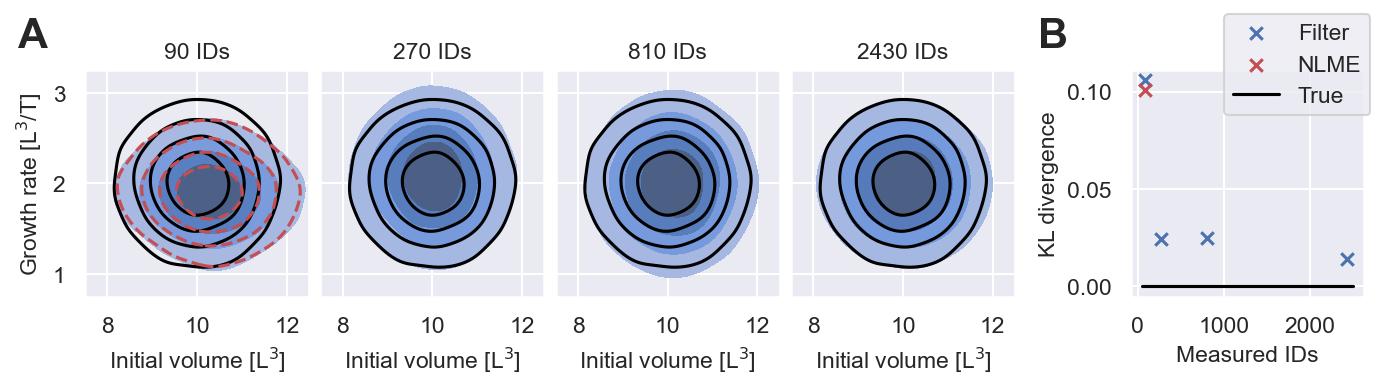

In [18]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 500 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.2, width_ratios=[4, 1])

# Create time series axes
inner = gridspec.GridSpecFromSubplotSpec(
    1, 4, subplot_spec=outer[0], wspace=0.05)

# Create axes for posteriors
axes = []
axes.append(plt.Subplot(fig, inner[0]))
axes.append(plt.Subplot(fig, inner[1]))
axes.append(plt.Subplot(fig, inner[2]))
axes.append(plt.Subplot(fig, inner[3]))
axes.append(plt.Subplot(fig, outer[1]))

# Share axes
for idx in range(3):
    axes[idx].sharex(axes[idx+1])
    axes[idx].sharey(axes[idx+1])

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Add subplot labels
# Label subplot groups
axes[0].text(
    -0.3, 1.1, string.ascii_uppercase[0], transform=axes[0].transAxes,
    size=20, weight='bold')
axes[-1].text(
    -0.4, 1.1, string.ascii_uppercase[1], transform=axes[-1].transAxes,
    size=20, weight='bold')

# Simulate data-generating process
seed = 13
n_samples = 50000
samples = population_model.sample(true_parameters, n_samples, seed=seed)

# Visualise inferred population distributions
population_samples = []
parameters = [
    'Mean Initial count', 'Mean Growth rate', 'Std. Initial count',
    'Std. Growth rate', 'Sigma Count']
for posterior in filter_results:
    posterior = np.vstack([
        posterior[p].values.flatten() for p in parameters]).T
    posterior = posterior[np.random.choice(
        np.arange(len(posterior)), size=n_samples, replace=True)]
    s = np.empty(shape=(n_samples, 3))
    for ids, params in enumerate(posterior):
        s[ids, :] = population_model.sample(params)[0]
    population_samples.append(s)

cross_entropies = []
for idx in range(len(population_samples)):
    label = None
    s = population_samples.pop(0)
    sns.kdeplot(
        x=s[:, 0], y=s[:, 1], fill=True, bw_adjust=1.5,
        levels=[0.2, 0.4, 0.6, 0.8, 1], ax=axes[idx])
    cross_entropies.append(
        np.mean(gaussian_kde(s[:, :2].T).logpdf(samples[:10000, :2].T)))
del s

# Plot data-generating distribution as reference
for idx, ax in enumerate(axes[:-1]):
    sns.kdeplot(
        x=samples[:, 0], y=samples[:, 1], fill=False, bw_adjust=1.5,
        levels=[0.2, 0.4, 0.6, 0.8, 1], ax=ax, color='black')

# Plot KL divergences
entropy = population_model.compute_log_likelihood(
    parameters=true_parameters, observations=samples) / n_samples
axes[4].scatter(
    [90, 270, 810, 2430], entropy - np.array(cross_entropies),
    color=sns.color_palette()[0], marker='x', label='Filter', zorder=10)

# Plot NLME results
# Visualise inferred population distributions
population_samples = []
parameters = [
    'Mean Initial count', 'Mean Growth rate', 'Std. Initial count',
    'Std. Growth rate', 'Pooled Sigma']
for posterior in [nlme_results[0]]:
    posterior = np.vstack([
        posterior[p].values.flatten() for p in parameters]).T
    posterior = posterior[np.random.choice(
        np.arange(len(posterior)), size=n_samples, replace=True)]
    s = np.empty(shape=(n_samples, 3))
    for ids, params in enumerate(posterior):
        s[ids, :] = population_model.sample(params)[0]
    population_samples.append(s)

cross_entropies = []
for idx in range(len(population_samples)):
    label = None
    s = population_samples.pop(0)
    sns.kdeplot(
        x=s[:, 0], y=s[:, 1], fill=False, bw_adjust=1.5,
        levels=[0.2, 0.4, 0.6, 0.8, 1], ax=axes[idx],
        color=sns.color_palette()[3], linestyles='--')
    cross_entropies.append(
        np.mean(gaussian_kde(s[:, :2].T).logpdf(samples[:10000, :2].T)))
del s

# Plot entropy
axes[4].scatter(
    [90], entropy - np.array(cross_entropies),
    color=sns.color_palette()[3], marker='x', label='NLME', zorder=10)
axes[4].plot([50, 2500], [0, 0], color='black', label='True')

# Labelling
axes[0].set_xlim([7.5, 12.5])
axes[0].set_ylim([0.75, 3.25])
axes[0].tick_params(labelsize=fontsize)
axes[0].set_ylabel(r'Growth rate [L$^3$/T]', fontsize=fontsize)
for ax in axes[1:-1]:
    ax.set_yticklabels(labels=[], visible=False)
for idx, ax in enumerate(axes[:-1]):
    ax.set_title('%d IDs' % (n_ids_per_t[idx] * 6), fontsize=fontsize)
    ax.set_xlabel(r'Initial volume [L$^3$]', fontsize=fontsize)
axes[4].set_xlabel('Measured IDs', fontsize=fontsize)
axes[4].set_ylabel('KL divergence', fontsize=fontsize)
axes[4].legend(loc=[0.4, 0.8], fontsize=int(fontsize))


# Export figure
plt.savefig(
    directory + '/5_estimates_of_IIV.tif',
    bbox_inches='tight')
plt.savefig(
    directory + '/5_estimates_of_IIV.pdf',
    bbox_inches='tight')

plt.show()

## 3. Relationship to summary statistics-based ABC

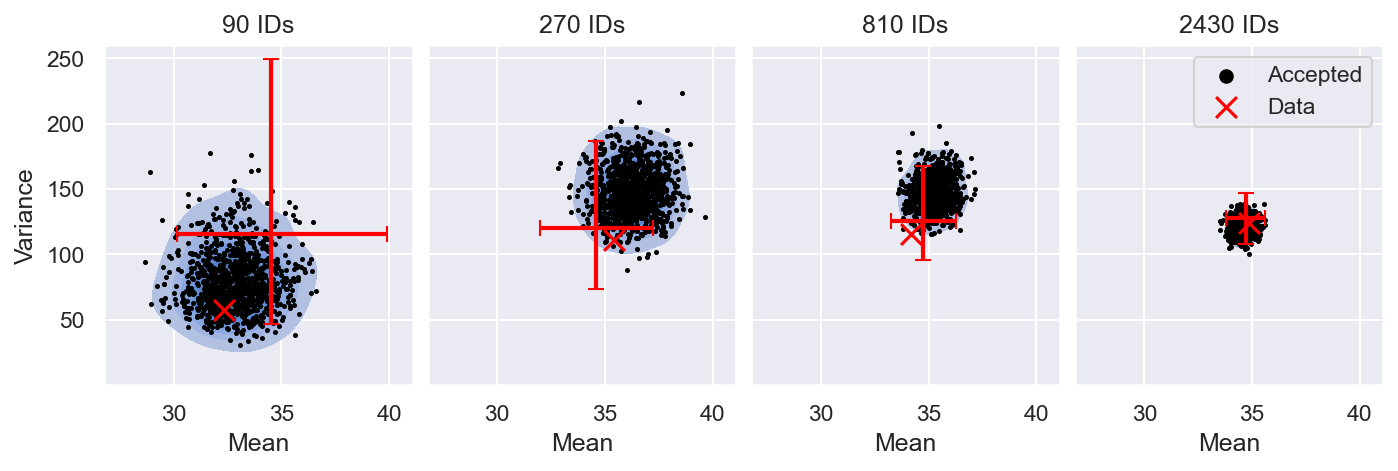

In [17]:
# Import Cancer modelling results
directory = os.getcwd()
measurements = []
cancer_results = []
for idn, n in enumerate([15, 45, 135, 405]):
    measurements.append(
        pd.read_csv(
            directory + '/data/1_cancer_growth_data_%d.csv' % n))
    cancer_results.append(
        xr.load_dataset(
            directory +
            '/posteriors/' +
            '%d_filter_inference_cancer_growth_%d.nc'% (idn + 2, n)))

# Compute means and variances
## Compute means and variances of data
time = 0.6
data_summary_stats = []
for data in measurements:
    mask = data.Time == time
    data = data[mask]
    data_summary_stats.append([
        np.mean(data.Value.values),
        np.var(data.Value.values, ddof=1)
    ])

# Define mechanistic model
model = ExponentialGrowthModel()

inference_summary_stats = []
for results in cancer_results:
    # Collect parameters of individuals across iterations
    parameters = np.vstack((
        results['Initial count'].values,
        results['Growth rate'].values,
        results['Count Epsilon time 6'].values
        ))

    # Scale parameters according to population parameters
    pop_parameters = np.vstack((
        results['Mean Initial count'].values[:, :, np.newaxis],
        results['Std. Initial count'].values[:, :, np.newaxis],
        results['Mean Growth rate'].values[:, :, np.newaxis],
        results['Std. Growth rate'].values[:, :, np.newaxis],
        results['Sigma Count'].values[:, :, np.newaxis]
        ))
    parameters[0] = pop_parameters[0] + pop_parameters[1] * parameters[0]
    parameters[1] = pop_parameters[2] + pop_parameters[3] * parameters[1]
    parameters[2] = pop_parameters[4] * parameters[2]

    # Compute mean and variance for each iteration
    times = [time]
    _, n_iterations, n_ids = parameters.shape
    means = np.empty(shape=n_iterations)
    variances = np.empty(shape=n_iterations)
    sim_meas = np.empty(shape=n_ids)
    for n in range(n_iterations):
        for _id in range(n_ids):
            # Solve mechanistic model and add noise
            sim_meas[_id] = parameters[2, n, _id] + model.simulate(
                parameters=parameters[:2, n, _id], times=times)[0]

        # Compute mean and variance
        means[n] = np.mean(sim_meas)
        variances[n] = np.var(sim_meas, ddof=1)

    inference_summary_stats.append([means, variances])

## Estimate errors of data summary stats
error_model = chi.GaussianErrorModel()
population_model = chi.ComposedPopulationModel([
    chi.GaussianModel(n_dim=2, dim_names=['Initial count', 'Growth rate']),
    chi.PooledModel(dim_names=['Sigma'])])
predictive_model = chi.PredictiveModel(model, error_model)
predictive_model = chi.PopulationPredictiveModel(
    predictive_model, population_model)
population_parameters = [
    10,    # Mean initial condition
    2,     # Mean exponential growth
    1,     # Std. initial condition
    0.5,   # Std. exponential growth
    0.8]   # Sigma

n_samples = 1000
errors = np.empty(shape=(4, 6, 1))
for ids, sim in enumerate([15, 45, 135, 405]):
    m = []
    v = []
    for n in range(n_samples):
        meas = predictive_model.sample(
            parameters=population_parameters, times=times, n_samples=sim,
            return_df=False)[0, 0]
        m.append(np.mean(meas))
        v.append(np.var(meas, ddof=1))
    errors[ids, 0] = np.percentile(m, q=50)
    errors[ids, 1] = errors[ids, 0] - np.percentile(m, q=5)
    errors[ids, 2] = np.percentile(m, q=95) - errors[ids, 0]
    errors[ids, 3] = np.percentile(v, q=50)
    errors[ids, 4] = errors[ids, 3] - np.percentile(v, q=5)
    errors[ids, 5] = np.percentile(v, q=95) - errors[ids, 3]

# Plot results
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 600 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 4, wspace=0.05)

# Create axis for data
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))
axes.append(plt.Subplot(fig, outer[3]))
axes[0].sharex(axes[1])
axes[1].sharex(axes[2])
axes[2].sharex(axes[3])

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

axes[3].scatter(
        [33], [1000], color='black', label='Accepted')
for idx, ax in enumerate(axes):
    # Plot accepted means and variances
    sns.kdeplot(
        x=inference_summary_stats[idx][0], y=inference_summary_stats[idx][1],
        ax=ax, bw_adjust=1.5, fill=True)
    ax.scatter(
        inference_summary_stats[idx][0], inference_summary_stats[idx][1],
        s=2, color='black')

    # Plot data mean and variance
    axes[idx].errorbar(
        x=[errors[idx, 0]], y=[errors[idx, 3]],
        xerr=errors[idx, 1:3],
        yerr=errors[idx, 4:],
        capsize=4,
        elinewidth=2, marker=None, color='red')
    axes[idx].scatter(
        [data_summary_stats[idx][0]], [data_summary_stats[idx][1]],
        marker='x', color='red', label='Data', s=100)

# Labelling
axes[0].set_xlabel('Mean')
axes[1].set_xlabel('Mean')
axes[2].set_xlabel('Mean')
axes[3].set_xlabel('Mean')
axes[0].set_ylabel('Variance')
axes[0].set_ylim([0.25, 260])
axes[1].set_ylim([0.25, 260])
axes[2].set_ylim([0.25, 260])
axes[3].set_ylim([0.25, 260])
axes[1].set_yticklabels([])
axes[2].set_yticklabels([])
axes[3].set_yticklabels([])
axes[0].set_title('90 IDs')
axes[1].set_title('270 IDs')
axes[2].set_title('810 IDs')
axes[3].set_title('2430 IDs')
axes[3].legend()

directory = os.getcwd()
plt.savefig(
    directory + '/11_relationship_to_summary_statistics_abc.tif',
    bbox_inches='tight')
plt.savefig(
    directory + '/11_relationship_to_summary_statistics_abc.pdf',
    bbox_inches='tight')

plt.show()

### 4. Information loss experiment 1

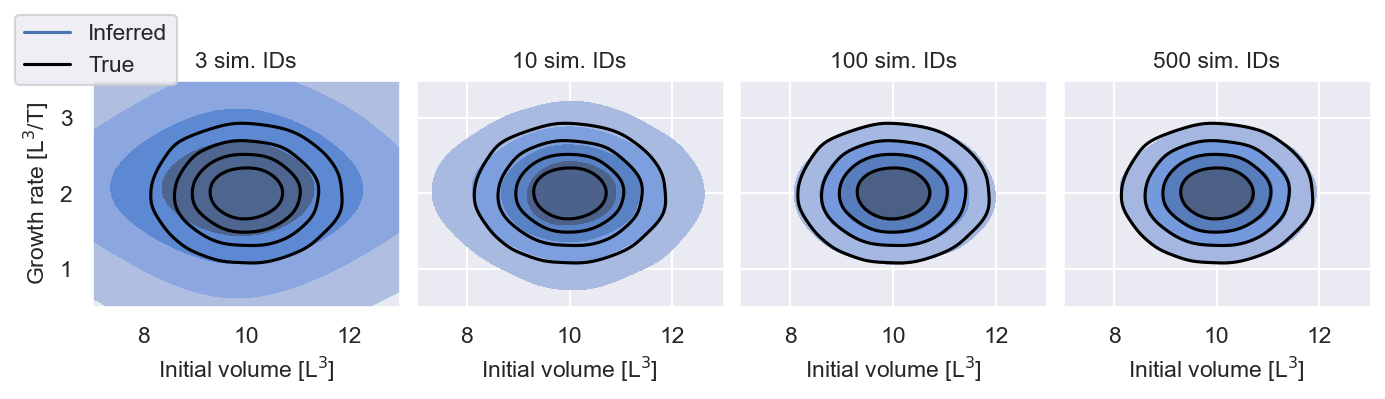

In [18]:
# Import filter inference results
n_sim = [3, 10, 100, 500]
filter_results = []
for idn, n in enumerate(n_sim):
    filter_results.append(xr.load_dataset(
        directory + '/posteriors/%d_filter_inference_cancer_growth_%d_ids.nc'
        % (idn+6, n)))

# Plot results
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 500 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 4, wspace=0.05)

# Create axes for posteriors
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))
axes.append(plt.Subplot(fig, outer[3]))

# Share axes
for idx in range(3):
    axes[idx].sharex(axes[idx+1])
    axes[idx].sharey(axes[idx+1])

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Visualise inferred population distributions
n_samples = 50000
population_samples = []
parameters = [
    'Mean Initial count', 'Mean Growth rate', 'Std. Initial count',
    'Std. Growth rate', 'Sigma Count']
for posterior in filter_results:
    posterior = np.vstack([
        posterior[p].values.flatten() for p in parameters]).T
    posterior = posterior[np.random.choice(
        np.arange(len(posterior)), size=n_samples, replace=True)]
    samples = np.empty(shape=(n_samples, 3))
    for ids, params in enumerate(posterior):
        samples[ids, :] = population_model.sample(params)[0]
    population_samples.append(samples)

for idx, samples in enumerate(population_samples):
    label = None
    sns.kdeplot(
        x=samples[:, 0], y=samples[:, 1], fill=True, bw_adjust=1.5,
        levels=[0.2, 0.4, 0.6, 0.8, 1], ax=axes[idx])

# Plot data-generating distribution as reference
samples = population_model.sample(true_parameters, n_samples)
for idx, ax in enumerate(axes):
    sns.kdeplot(
        x=samples[:, 0], y=samples[:, 1], fill=False, bw_adjust=1.5,
        levels=[0.2, 0.4, 0.6, 0.8, 1], ax=ax, color='black')
axes[0].set_xlim([7, 13])
axes[0].set_ylim([0.5, 3.5])
axes[0].tick_params(labelsize=fontsize)
axes[0].set_ylabel(r'Growth rate [L$^3$/T]', fontsize=fontsize)
for ax in axes[1:]:
    ax.set_yticklabels(labels=[], visible=False)
for idx, ax in enumerate(axes):
    ax.set_title('%d sim. IDs' % (n_sim[idx]), fontsize=fontsize)
    ax.set_xlabel(r'Initial volume [L$^3$]', fontsize=fontsize)

# Add legend
axes[0].plot(
    [111, 111], [111, 111], color=sns.color_palette()[0], label='Inferred')
axes[0].plot(
    [111, 111], [111, 111], color='black', label='True')
axes[0].legend(loc=[-0.25, 0.98], fontsize=int(fontsize))

# Export figure
plt.savefig(
    directory + '/12_information_loss_1.tif',
    bbox_inches='tight')
plt.savefig(
    directory + '/12_information_loss_1.pdf',
    bbox_inches='tight')

plt.show()

### 5. Information loss experiment II

Import results

In [133]:
# Define population model
growth_rate_model = chi.CovariatePopulationModel(
    chi.GaussianModel(),
    chi.LinearCovariateModel(cov_names=['Shift aggressive variant']),
    dim_names=['Growth rate'])
growth_rate_model.set_population_parameters([(0, 0)])
population_model = chi.ComposedPopulationModel([
    chi.GaussianModel(n_dim=1, dim_names=['Initial count']),
    growth_rate_model,
    chi.PooledModel(dim_names=['Sigma'])])

# Define data-generating parameters
true_parameters = [
    10,    # Mean initial condition
    1,     # Std. initial condition
    2,     # Mean exponential growth (slow variant)
    0.5,   # Std. exponential growth
    2,     # Growth increase (fast variant)
    0.8]   # Sigma

# Import NLME inference results
nlme_results = xr.load_dataset(
    directory + '/posteriors/11_nlme_inference_bimodal_cancer_growth.nc')

# Import filter inference results
filter_results = []
filters = [
        'gaussian', 'lognormal', 'gaussian_mixture', 'gaussian_kde',
        'lognormal_kde']
for idn, n in enumerate([20, 500]):
    for idf, f in enumerate(filters):
        filter_results.append(xr.load_dataset(
            directory + '/posteriors/'
            '%d_filter_inference_bimodal_cancer_growth_%s_filter_%d.nc'
            % (idn*5+idf+12, f, n)))


Visualise results

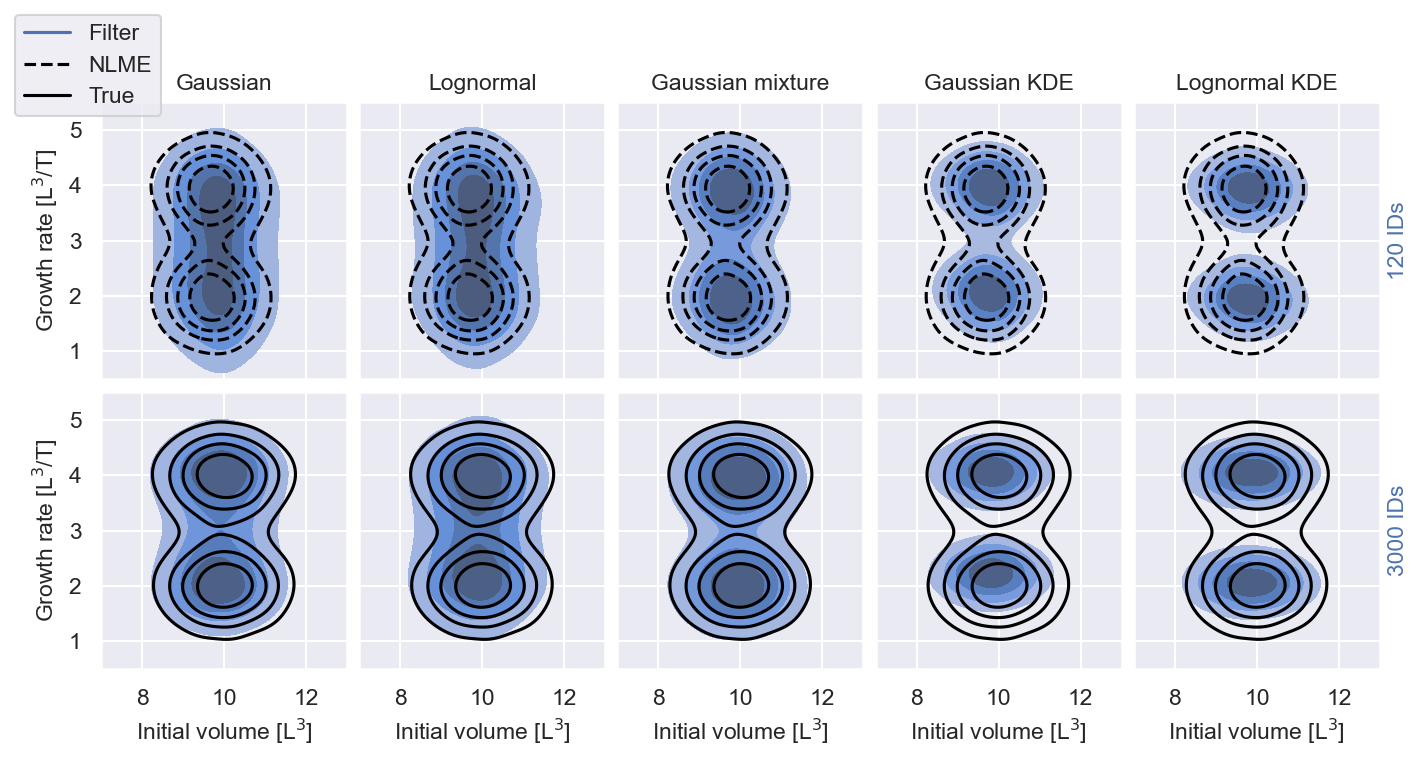

In [127]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1000 // my_dpi), dpi=150)
outer = gridspec.GridSpec(2, 5, wspace=0.05, hspace=0.05)

# Create axes for posteriors
axes = []
axes.append(plt.Subplot(fig, outer[0, 0]))
axes.append(plt.Subplot(fig, outer[0, 1]))
axes.append(plt.Subplot(fig, outer[0, 2]))
axes.append(plt.Subplot(fig, outer[0, 3]))
axes.append(plt.Subplot(fig, outer[0, 4]))
axes.append(plt.Subplot(fig, outer[1, 0]))
axes.append(plt.Subplot(fig, outer[1, 1]))
axes.append(plt.Subplot(fig, outer[1, 2]))
axes.append(plt.Subplot(fig, outer[1, 3]))
axes.append(plt.Subplot(fig, outer[1, 4]))

# Share axes
for idx in range(9):
    axes[idx].sharex(axes[idx+1])
    axes[idx].sharey(axes[idx+1])

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# # Visualise inferred population distributions
n_samples = 50000
population_samples = []
parameters = [
    'Mean Initial volume', 'Std. Initial volume', 'Mean Growth rate',
    'Std. Growth rate', 'Mean Growth rate Aggressive variant',
    'Sigma Tumour volume']
for idx, posterior in enumerate(filter_results):
    posterior = np.vstack([
        posterior[p].values.flatten() for p in parameters]).T
    posterior = posterior[np.random.choice(
        np.arange(len(posterior)), size=n_samples, replace=True)]
    samples = np.empty(shape=(n_samples, 3))
    covariates = [0]
    for ids, params in enumerate(posterior):
        if ids > n_samples//2:
            covariates = [1]
        samples[ids, :] = population_model.sample(
            params, covariates=covariates)[0]
    population_samples.append(samples)

for idx, samples in enumerate(population_samples):
    sns.kdeplot(
        x=samples[:, 0], y=samples[:, 1], fill=True, bw_adjust=1.5,
        levels=[0.2, 0.4, 0.6, 0.8, 1], ax=axes[idx])

# Visualise NLME inference population distributions, where possible
parameters = [
    'Mean Initial volume', 'Std. Initial volume', 'Mean Growth rate',
    'Std. Growth rate', 'Mean Growth rate Aggressive variant',
    'Pooled Sigma']
posterior = np.vstack([
    nlme_results[p].values.flatten() for p in parameters]).T
posterior = posterior[np.random.choice(
    np.arange(len(posterior)), size=n_samples, replace=True)]
samples = np.empty(shape=(n_samples, 3))
covariates = [0]
for ids, params in enumerate(posterior):
    if ids > n_samples//2:
        covariates = [1]
    samples[ids, :] = population_model.sample(params, covariates=covariates)[0]

for idx, ax in enumerate(axes[:5]):
    sns.kdeplot(
        x=samples[:, 0], y=samples[:, 1], fill=False, bw_adjust=1.5,
        levels=[0.2, 0.4, 0.6, 0.8, 1], ax=axes[idx],
        linestyles='--', color='black', zorder=10)

# Plot data-generating distribution as reference
samples = np.empty(shape=(n_samples, 3))
samples[:n_samples//2] = population_model.sample(
    true_parameters, n_samples//2, covariates=[0])
samples[n_samples//2:] = population_model.sample(
    true_parameters, n_samples//2, covariates=[1])
for idx, ax in enumerate(axes[5:]):
    sns.kdeplot(
        x=samples[:, 0], y=samples[:, 1], fill=False, bw_adjust=1.5,
        levels=[0.2, 0.4, 0.6, 0.8, 1], ax=ax, color='black')
axes[0].set_xlim([7, 13])
axes[0].set_ylim([0.5, 5.5])
axes[0].tick_params(labelsize=fontsize)
axes[0].set_ylabel(r'Growth rate [L$^3$/T]', fontsize=fontsize)
axes[5].set_ylabel(r'Growth rate [L$^3$/T]', fontsize=fontsize)
for ida, ax in enumerate(axes):
    if (ida == 0) or (ida == 5):
        continue
    ax.set_yticklabels(labels=[], visible=False)
filters = [
    'Gaussian', 'Lognormal', 'Gaussian mixture', 'Gaussian KDE',
    'Lognormal KDE']
for idx, ax in enumerate(axes[:5]):
    ax.set_title(filters[idx], fontsize=fontsize)
for ax in axes[5:]:
    ax.set_xlabel(r'Initial volume [L$^3$]', fontsize=fontsize)
labels = ['120 IDs', '3000 IDs']
for idx, ax in enumerate([axes[4], axes[9]]):
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(labels[idx], fontsize=fontsize, color=sns.color_palette()[0])

# Add legend
axes[0].plot(
    [111, 111], [111, 111], color=sns.color_palette()[0], label='Filter')
axes[0].plot(
    [111, 111], [111, 111], color='black', label='NLME',
    linestyle='--')
axes[0].plot(
    [111, 111], [111, 111], color='black', label='True')
axes[0].legend(loc=[-0.35, 0.95], fontsize=int(fontsize))

# Export figure
plt.savefig(
    directory + '/13_information_loss_2.tif',
    bbox_inches='tight')
plt.savefig(
    directory + '/13_information_loss_2.pdf',
    bbox_inches='tight')

plt.show()

## Information loss and bias: Gaussian KDE filter

In [134]:
filter_results[-2]

<xarray.Dataset>
Dimensions:                              (chain: 1, draw: 1000, individual: 100)
Coordinates:
  * chain                                (chain) int64 0
  * draw                                 (draw) int64 500 501 502 ... 1498 1499
  * individual                           (individual) object 'Sim. 1' ... 'Si...
Data variables: (12/14)
    Mean Initial volume                  (chain, draw) float64 9.811 ... 9.707
    Std. Initial volume                  (chain, draw) float64 0.7305 ... 0.8316
    Mean Growth rate                     (chain, draw) float64 2.335 ... 2.339
    Std. Growth rate                     (chain, draw) float64 0.2787 ... 0.2545
    Mean Growth rate Aggressive variant  (chain, draw) float64 1.772 ... 1.717
    Sigma Tumour volume                  (chain, draw) float64 0.8848 ... 0.7797
    ...                                   ...
    Tumour volume Epsilon time 1         (chain, draw, individual) float64 0....
    Tumour volume Epsilon time 2         (chain, draw, individual) float64 1....
    Tumour volume Epsilon time 3         (chain, draw, individual) float64 0....
    Tumour volume Epsilon time 4         (chain, draw, individual) float64 -0...
    Tumour volume Epsilon time 5         (chain, draw, individual) float64 1....
    Tumour volume Epsilon time 6         (chain, draw, individual) float64 0....
Attributes:
    divergent iterations:          true
    divergent iterations chain 0:  [  1   2   3   4   5   6   7   8  13  17  ...

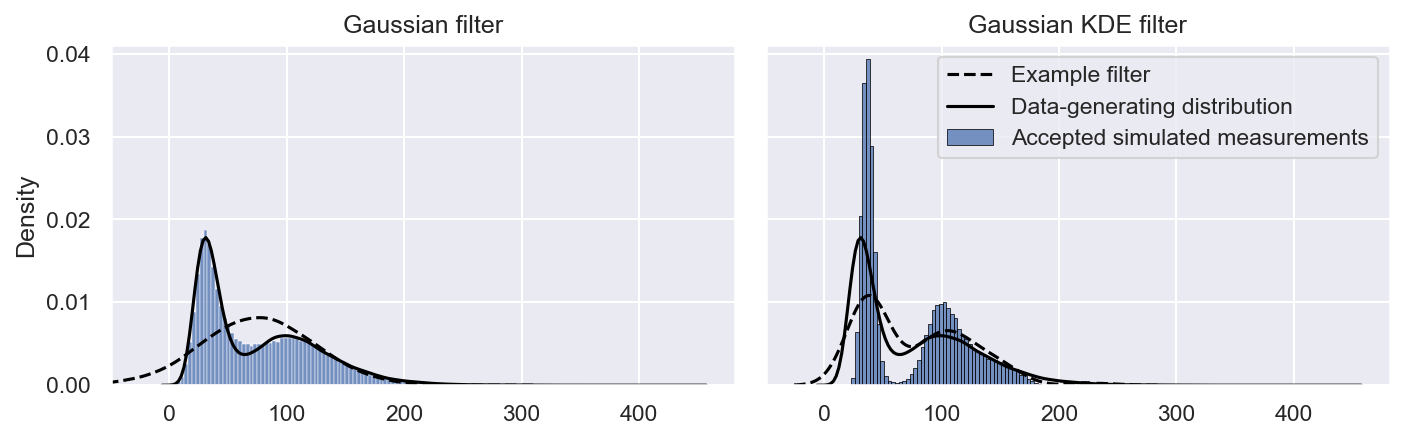

In [174]:
# Define model
mechanistic_model = ExponentialGrowthModel()
growth_rate_model = chi.CovariatePopulationModel(
    chi.GaussianModel(),
    chi.LinearCovariateModel(cov_names=['Shift aggressive variant']),
    dim_names=['Growth rate'])
growth_rate_model.set_population_parameters([(0, 0)])
population_model = chi.ComposedPopulationModel([
    chi.GaussianModel(n_dim=1, dim_names=['Initial count']),
    growth_rate_model,
    chi.PooledModel(dim_names=['Sigma'])])

# Define data-generating parameters
true_parameters = [
    10,    # Mean initial condition
    1,     # Std. initial condition
    2,     # Mean exponential growth (slow variant)
    0.5,   # Std. exponential growth
    2,     # Growth increase (fast variant)
    0.8]   # Sigma

# Reshape posterior
results = filter_results[-5]
parameters = np.vstack((
    results['Initial volume'].values,
    results['Growth rate'].values,
    results['Tumour volume Epsilon time 6'].values
    ))

# Scale parameters according to population parameters
pop_parameters = np.vstack((
    results['Mean Initial volume'].values[:, :, np.newaxis],
    results['Std. Initial volume'].values[:, :, np.newaxis],
    results['Mean Growth rate'].values[:, :, np.newaxis],
    results['Std. Growth rate'].values[:, :, np.newaxis],
    results['Mean Growth rate Aggressive variant'].values[:, :, np.newaxis],
    results['Sigma Tumour volume'].values[:, :, np.newaxis]
    ))
covariates = np.zeros(shape=parameters.shape[1:])
covariates[:, 50:] += 1
parameters[0] = pop_parameters[0] + pop_parameters[1] * parameters[0]
parameters[1] = \
    pop_parameters[2] + pop_parameters[4] * covariates \
    + pop_parameters[3] * parameters[1]
parameters[2] = pop_parameters[5] * parameters[2]

# Simulate measurements
times = [0.6]
_, n_iterations, n_ids = parameters.shape
sim_meas1 = np.empty(shape=(n_iterations, n_ids))
for n in range(n_iterations):
    for _id in range(n_ids):
        # Solve mechanistic model and add noise
        sim_meas1[n, _id] = parameters[2, n, _id] + mechanistic_model.simulate(
            parameters=parameters[:2, n, _id], times=times)[0]

# Reshape posterior
results = filter_results[-2]
parameters = np.vstack((
    results['Initial volume'].values,
    results['Growth rate'].values,
    results['Tumour volume Epsilon time 6'].values
    ))

# Scale parameters according to population parameters
pop_parameters = np.vstack((
    results['Mean Initial volume'].values[:, :, np.newaxis],
    results['Std. Initial volume'].values[:, :, np.newaxis],
    results['Mean Growth rate'].values[:, :, np.newaxis],
    results['Std. Growth rate'].values[:, :, np.newaxis],
    results['Mean Growth rate Aggressive variant'].values[:, :, np.newaxis],
    results['Sigma Tumour volume'].values[:, :, np.newaxis]
    ))
covariates = np.zeros(shape=parameters.shape[1:])
covariates[:, 50:] += 1
parameters[0] = pop_parameters[0] + pop_parameters[1] * parameters[0]
parameters[1] = \
    pop_parameters[2] + pop_parameters[4] * covariates \
    + pop_parameters[3] * parameters[1]
parameters[2] = pop_parameters[5] * parameters[2]

# Simulate measurements
times = [0.6]
_, n_iterations, n_ids = parameters.shape
sim_meas2 = np.empty(shape=(n_iterations, n_ids))
for n in range(n_iterations):
    for _id in range(n_ids):
        # Solve mechanistic model and add noise
        sim_meas2[n, _id] = parameters[2, n, _id] + mechanistic_model.simulate(
            parameters=parameters[:2, n, _id], times=times)[0]

# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.05, hspace=0.05)

# Create axes for posteriors
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot histogram over accepted samples
sns.histplot(x=sim_meas1.flatten(), fill=True, ax=axes[0], stat='density')
sns.histplot(
    x=sim_meas2.flatten(), fill=True, ax=axes[1], stat='density',
    edgecolor='black',
    color=sns.color_palette()[0], label='Accepted simulated measurements')
mean = np.mean(sim_meas1[0])
std = np.std(sim_meas1[0])
sns.kdeplot(
    x=np.random.normal(loc=mean, scale=std, size=10000), fill=False,
    ax=axes[0], color='black', linestyle='--',
    label='Example filter', bw_adjust=1.5)

# sns.histplot(
#     x=sim_meas2[0], fill=False, ax=axes[1], stat='density', binwidth=5,
#     color=sns.color_palette()[3], label='Example accepted sim. meas.',
#     element='step')
sns.kdeplot(
    x=sim_meas2[0], fill=False, ax=axes[1], color='black', linestyle='--',
    label='Example filter')

# Plot data-generating distribution
covariates = covariates.flatten()[:, np.newaxis]
samples = population_model.sample(
    true_parameters, n_samples=len(covariates), covariates=covariates)
meas = np.empty(len(covariates))
for idx, sample in enumerate(samples):
    # Solve mechanistic model and add noise
    meas[idx] = \
        np.random.normal(loc=0, scale=true_parameters[-1]) \
        + mechanistic_model.simulate(parameters=sample[:-1], times=times)[0]

sns.kdeplot(x=meas.flatten(), fill=False, ax=axes[0], color='black')
sns.kdeplot(
    x=meas.flatten(), fill=False, ax=axes[1], color='black',
    label='Data-generating distribution')

# Labelling
axes[0].set_title('Gaussian filter')
axes[1].set_title('Gaussian KDE filter')
axes[0].sharex(axes[1])
axes[0].set_ylim([0, 0.041])
axes[1].set_ylim([0, 0.041])
axes[1].get_yaxis().set_ticklabels([])
axes[1].set_ylabel('')
axes[1].legend()

plt.savefig(
    directory + '/S5_accepted_simulated_measurements.tif',
    bbox_inches='tight')
plt.savefig(
    directory + '/S5_accepted_simulated_measurements.pdf',
    bbox_inches='tight')

plt.show()